In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

### Loading the Fashion MNIST dataset

In [2]:
fmnist = FashionMNIST(root = 'data', train = True, download = True, transform = Compose([ToTensor(),Normalize(mean=(0.5,), std = (0.5,))]))

In [3]:
#selecting the image from dataset, img represents image data, label represents 0 or 1.
img, label = fmnist[0]
print('label ',(label))
#Selecting a subset of image pixels from rows 10 to 14(inclusive), and columns 10 to 14(inclusive)
print(img[:,10:15, 10:15])
torch.min(img),torch.max(img)

label  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [4]:
#Denormalizing the image using the below function and clamp restricts the image to be in the mentioned pixel value(0,1) instead of (-1,1)
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

label  9


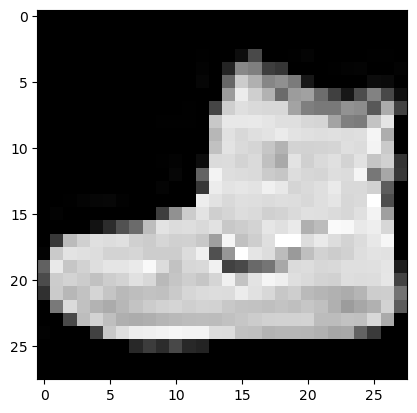

In [5]:
#selecting a image of fmnist[0] and showing the image.
import matplotlib.pyplot as plt
%matplotlib inline

denorm_img = denorm(img)
plt.imshow(denorm_img[0],cmap='gray')
print('label ', label)



In [6]:
#Creating a dataloader for fashionmnist dataset for batchsize = 100.
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fmnist,batch_size,shuffle = True)

first_batch
torch.Size([100, 1, 28, 28])
tensor([1, 9, 2, 2, 0, 1, 1, 3, 1, 6, 6, 0, 7, 0, 4, 5, 7, 1, 6, 2, 6, 2, 4, 4,
        5, 4, 3, 8, 5, 3, 5, 8, 1, 0, 0, 9, 0, 5, 6, 8, 1, 1, 4, 0, 3, 2, 6, 4,
        6, 7, 3, 0, 1, 6, 2, 2, 8, 0, 7, 2, 1, 8, 4, 6, 6, 8, 5, 9, 2, 2, 6, 0,
        1, 2, 4, 6, 0, 7, 9, 9, 6, 9, 8, 0, 2, 4, 4, 8, 2, 4, 9, 6, 6, 9, 6, 0,
        0, 8, 6, 5])


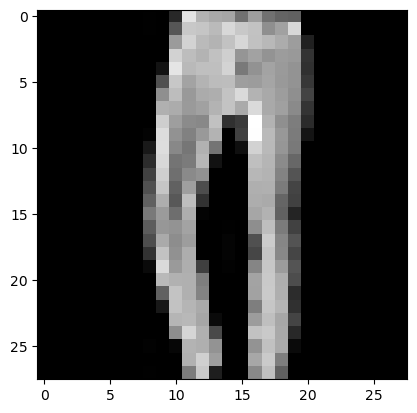

In [7]:
for image_batch, label_batch in data_loader:
    print('first_batch')
    print(image_batch.shape)
    plt.imshow(image_batch[0][0], cmap = 'gray')
    print(label_batch)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Discriminator Network

In [10]:
input_image_size = 784
hidden_size = 256

In [12]:
discriminator_lsgan = nn.Sequential(
    nn.Linear(input_image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
)

### Generator Network

In [13]:
# Define generator network
input_generator = 64

generator_lsgan = nn.Sequential(
    nn.Linear(input_generator, hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size, input_image_size),
    nn.Tanh()
)

In [14]:
#Detach is used when we dont want to flow back the gradients 
y = generator_lsgan(torch.randn(2, input_generator))
gen_imgs_gan = denorm(y.reshape((-1,28,28)).detach())

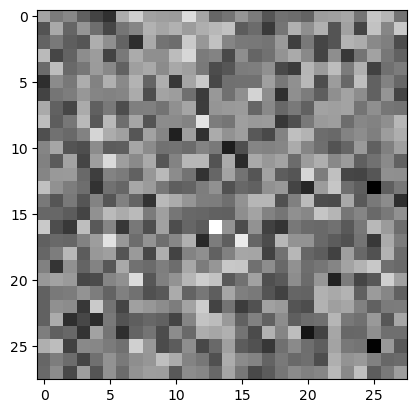

In [15]:
plt.imshow(gen_imgs_gan[0], cmap = 'gray')

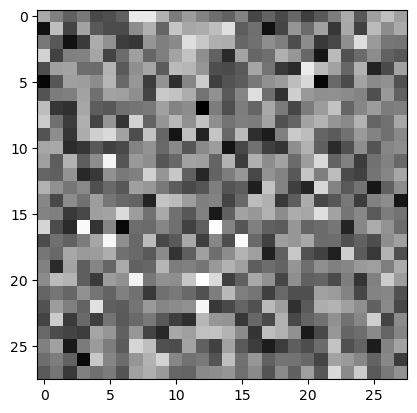

In [16]:
plt.imshow(gen_imgs_gan[1], cmap = 'gray')

In [17]:
generator_lsgan.to(device);
discriminator_lsgan.to(device);

### Discriminator training

In [20]:
# Define optimizers
d_optimizer_lsgan = torch.optim.Adam(discriminator_lsgan.parameters(), lr=0.0002)
g_optimizer_lsgan = torch.optim.Adam(generator_lsgan.parameters(), lr=0.0002)

# Define LSGAN loss function
lsgan_loss = nn.MSELoss()


In [21]:
def reset_grad():
    d_optimizer_lsgan.zero_grad()
    g_optimizer_lsgan.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator_lsgan(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator_lsgan(z)
    outputs = discriminator_lsgan(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer_lsgan.step()

    return d_loss, real_score, fake_score

### Generator Training

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator_lsgan(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator_lsgan(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer_lsgan.step()
    return g_loss, fake_images

### Train the model

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

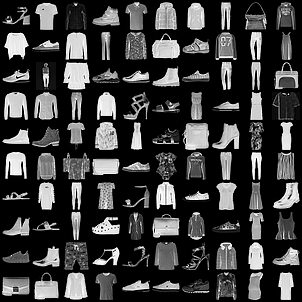

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


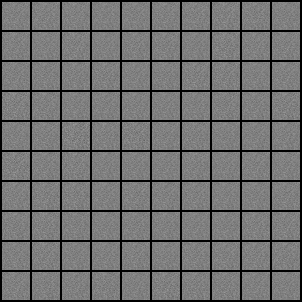

In [25]:
sample_vectors = torch.randn(batch_size, input_generator).to(device)

def save_fake_images(index):
    fake_images = generator_lsgan(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [26]:
# Training loop
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator loss for real images
        real_outputs = discriminator_lsgan(images)
        d_loss_real = lsgan_loss(real_outputs, real_labels)

        # Generate fake images and compute discriminator loss for fake images
        z = torch.randn(batch_size, input_generator).to(device)
        fake_images = generator_lsgan(z)
        fake_outputs = discriminator_lsgan(fake_images.detach())
        d_loss_fake = lsgan_loss(fake_outputs, fake_labels)

        # Combine discriminator losses
        d_loss = d_loss_real + d_loss_fake

        # Backpropagation and optimization for discriminator
        d_optimizer_lsgan.zero_grad()
        d_loss.backward()
        d_optimizer_lsgan.step()

        # Train the generator
        fake_outputs = discriminator_lsgan(fake_images)
        g_loss = lsgan_loss(fake_outputs, real_labels)

        # Backpropagation and optimization for generator
        g_optimizer_lsgan.zero_grad()
        g_loss.backward()
        g_optimizer_lsgan.step()

        # Logging
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(torch.mean(real_outputs).item())
            fake_scores.append(torch.mean(fake_outputs).item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          torch.mean(real_outputs).item(), torch.mean(fake_outputs).item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0096, g_loss: 1.1389, D(x): 0.98, D(G(z)): -0.07
Epoch [0/300], Step [400/600], d_loss: 0.0128, g_loss: 1.2613, D(x): 0.97, D(G(z)): -0.12
Epoch [0/300], Step [600/600], d_loss: 0.0115, g_loss: 1.2992, D(x): 0.99, D(G(z)): -0.14
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0088, g_loss: 1.2836, D(x): 1.01, D(G(z)): -0.13
Epoch [1/300], Step [400/600], d_loss: 0.0118, g_loss: 1.1351, D(x): 0.98, D(G(z)): -0.07
Epoch [1/300], Step [600/600], d_loss: 0.0061, g_loss: 1.2318, D(x): 0.98, D(G(z)): -0.11
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0090, g_loss: 1.2403, D(x): 0.97, D(G(z)): -0.11
Epoch [2/300], Step [400/600], d_loss: 0.0127, g_loss: 1.0036, D(x): 0.99, D(G(z)): -0.00
Epoch [2/300], Step [600/600], d_loss: 0.0158, g_loss: 1.0311, D(x): 0.95, D(G(z)): -0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0104, g_loss: 1.2273, D(x): 0.98, D(G(z)): -0.11
Epoch [3/300], S

Epoch [27/300], Step [600/600], d_loss: 0.2313, g_loss: 0.8230, D(x): 0.79, D(G(z)): 0.12
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.1566, g_loss: 0.8267, D(x): 0.88, D(G(z)): 0.11
Epoch [28/300], Step [400/600], d_loss: 0.1277, g_loss: 0.7306, D(x): 0.90, D(G(z)): 0.16
Epoch [28/300], Step [600/600], d_loss: 0.2394, g_loss: 0.8925, D(x): 0.75, D(G(z)): 0.09
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.1324, g_loss: 0.8943, D(x): 0.87, D(G(z)): 0.07
Epoch [29/300], Step [400/600], d_loss: 0.1218, g_loss: 0.9140, D(x): 0.90, D(G(z)): 0.06
Epoch [29/300], Step [600/600], d_loss: 0.2093, g_loss: 0.8053, D(x): 0.83, D(G(z)): 0.13
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.1661, g_loss: 0.7885, D(x): 0.88, D(G(z)): 0.13
Epoch [30/300], Step [400/600], d_loss: 0.1627, g_loss: 0.8158, D(x): 0.80, D(G(z)): 0.11
Epoch [30/300], Step [600/600], d_loss: 0.1994, g_loss: 0.8032, D(x): 0.72, D(G(z)): 0.12
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.3977, g_loss: 0.5939, D(x): 0.65, D(G(z)): 0.26
Epoch [55/300], Step [600/600], d_loss: 0.3303, g_loss: 0.5715, D(x): 0.67, D(G(z)): 0.27
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.2782, g_loss: 0.5119, D(x): 0.77, D(G(z)): 0.31
Epoch [56/300], Step [400/600], d_loss: 0.2053, g_loss: 0.8517, D(x): 0.78, D(G(z)): 0.10
Epoch [56/300], Step [600/600], d_loss: 0.2731, g_loss: 0.4996, D(x): 0.72, D(G(z)): 0.31
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.2680, g_loss: 0.6032, D(x): 0.76, D(G(z)): 0.25
Epoch [57/300], Step [400/600], d_loss: 0.3064, g_loss: 0.6502, D(x): 0.72, D(G(z)): 0.22
Epoch [57/300], Step [600/600], d_loss: 0.4027, g_loss: 0.4960, D(x): 0.62, D(G(z)): 0.33
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.1863, g_loss: 0.7340, D(x): 0.82, D(G(z)): 0.17
Epoch [58/300], Step [400/600], d_loss: 0.3569, g_loss: 0.5125, D(x): 0.66, D(G(z)): 0.32
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.3491, g_loss: 0.5483, D(x): 0.62, D(G(z)): 0.29
Epoch [83/300], Step [400/600], d_loss: 0.2826, g_loss: 0.7270, D(x): 0.70, D(G(z)): 0.17
Epoch [83/300], Step [600/600], d_loss: 0.4192, g_loss: 0.3593, D(x): 0.66, D(G(z)): 0.43
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.2236, g_loss: 0.6737, D(x): 0.74, D(G(z)): 0.20
Epoch [84/300], Step [400/600], d_loss: 0.3613, g_loss: 0.4792, D(x): 0.76, D(G(z)): 0.35
Epoch [84/300], Step [600/600], d_loss: 0.2383, g_loss: 0.6384, D(x): 0.76, D(G(z)): 0.23
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.3352, g_loss: 0.5630, D(x): 0.74, D(G(z)): 0.29
Epoch [85/300], Step [400/600], d_loss: 0.2754, g_loss: 0.5135, D(x): 0.76, D(G(z)): 0.31
Epoch [85/300], Step [600/600], d_loss: 0.3058, g_loss: 0.5904, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.2684, g_loss: 0.6168, D(x): 0.71, D(G(z)): 0.23
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.3410, g_loss: 0.5244, D(x): 0.69, D(G(z)): 0.30
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.1851, g_loss: 0.7173, D(x): 0.75, D(G(z)): 0.17
Epoch [111/300], Step [400/600], d_loss: 0.3833, g_loss: 0.5581, D(x): 0.67, D(G(z)): 0.29
Epoch [111/300], Step [600/600], d_loss: 0.3180, g_loss: 0.5345, D(x): 0.63, D(G(z)): 0.29
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.2883, g_loss: 0.5548, D(x): 0.70, D(G(z)): 0.29
Epoch [112/300], Step [400/600], d_loss: 0.2762, g_loss: 0.5200, D(x): 0.75, D(G(z)): 0.31
Epoch [112/300], Step [600/600], d_loss: 0.2736, g_loss: 0.6077, D(x): 0.67, D(G(z)): 0.24
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.2838, g_loss: 0.4967, D(x): 0.79, D(G(z)): 0.33
Epoch [113/300], Step [400/600], d_loss: 0.2940, g_loss: 0.5768, D(x): 0.73, D(G(z)): 0.27
Epoch [113/300], Step [600/600], d_loss: 0.2814, g_loss: 0.5967, D(x): 0.75, D(G(z)): 0.26
Saving

Epoch [138/300], Step [200/600], d_loss: 0.3416, g_loss: 0.4929, D(x): 0.68, D(G(z)): 0.33
Epoch [138/300], Step [400/600], d_loss: 0.2629, g_loss: 0.7135, D(x): 0.65, D(G(z)): 0.18
Epoch [138/300], Step [600/600], d_loss: 0.2569, g_loss: 0.6323, D(x): 0.72, D(G(z)): 0.23
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.2564, g_loss: 0.6558, D(x): 0.75, D(G(z)): 0.22
Epoch [139/300], Step [400/600], d_loss: 0.3302, g_loss: 0.5084, D(x): 0.69, D(G(z)): 0.31
Epoch [139/300], Step [600/600], d_loss: 0.2402, g_loss: 0.5757, D(x): 0.79, D(G(z)): 0.27
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.2955, g_loss: 0.6016, D(x): 0.64, D(G(z)): 0.25
Epoch [140/300], Step [400/600], d_loss: 0.2491, g_loss: 0.6037, D(x): 0.74, D(G(z)): 0.25
Epoch [140/300], Step [600/600], d_loss: 0.3506, g_loss: 0.4366, D(x): 0.67, D(G(z)): 0.36
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.3054, g_loss: 0.5712, D(x): 0.67, D(G(z)): 0.27
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.3505, g_loss: 0.4757, D(x): 0.73, D(G(z)): 0.34
Epoch [165/300], Step [600/600], d_loss: 0.3152, g_loss: 0.5305, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.3897, g_loss: 0.4590, D(x): 0.66, D(G(z)): 0.35
Epoch [166/300], Step [400/600], d_loss: 0.4029, g_loss: 0.5418, D(x): 0.53, D(G(z)): 0.29
Epoch [166/300], Step [600/600], d_loss: 0.3649, g_loss: 0.4290, D(x): 0.69, D(G(z)): 0.37
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.3210, g_loss: 0.4981, D(x): 0.71, D(G(z)): 0.32
Epoch [167/300], Step [400/600], d_loss: 0.3371, g_loss: 0.4879, D(x): 0.72, D(G(z)): 0.32
Epoch [167/300], Step [600/600], d_loss: 0.3259, g_loss: 0.4898, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.2550, g_loss: 0.5943, D(x): 0.75, D(G(z)): 0.26
Epoch [168/300], Step [400/600], d_loss: 0.1956, g_loss: 0.7031, D(x): 0.79, D(G(z)): 0.19
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.2103, g_loss: 0.6615, D(x): 0.81, D(G(z)): 0.21
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.2625, g_loss: 0.6725, D(x): 0.72, D(G(z)): 0.22
Epoch [193/300], Step [400/600], d_loss: 0.2348, g_loss: 0.6134, D(x): 0.77, D(G(z)): 0.25
Epoch [193/300], Step [600/600], d_loss: 0.2952, g_loss: 0.5767, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.2464, g_loss: 0.6337, D(x): 0.82, D(G(z)): 0.24
Epoch [194/300], Step [400/600], d_loss: 0.2662, g_loss: 0.6214, D(x): 0.75, D(G(z)): 0.24
Epoch [194/300], Step [600/600], d_loss: 0.2208, g_loss: 0.6770, D(x): 0.78, D(G(z)): 0.20
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.2593, g_loss: 0.6381, D(x): 0.76, D(G(z)): 0.22
Epoch [195/300], Step [400/600], d_loss: 0.3003, g_loss: 0.5601, D(x): 0.68, D(G(z)): 0.28
Epoch [195/300], Step [600/600], d_loss: 0.3162, g_loss: 0.5048, D(x): 0.73, D(G(z)): 0.33
Saving

Epoch [220/300], Step [200/600], d_loss: 0.3368, g_loss: 0.4830, D(x): 0.69, D(G(z)): 0.33
Epoch [220/300], Step [400/600], d_loss: 0.2892, g_loss: 0.5699, D(x): 0.78, D(G(z)): 0.28
Epoch [220/300], Step [600/600], d_loss: 0.2542, g_loss: 0.6203, D(x): 0.74, D(G(z)): 0.24
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.2092, g_loss: 0.6748, D(x): 0.79, D(G(z)): 0.21
Epoch [221/300], Step [400/600], d_loss: 0.3160, g_loss: 0.5048, D(x): 0.76, D(G(z)): 0.32
Epoch [221/300], Step [600/600], d_loss: 0.2839, g_loss: 0.6376, D(x): 0.68, D(G(z)): 0.23
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.2405, g_loss: 0.6303, D(x): 0.76, D(G(z)): 0.24
Epoch [222/300], Step [400/600], d_loss: 0.2855, g_loss: 0.5385, D(x): 0.67, D(G(z)): 0.29
Epoch [222/300], Step [600/600], d_loss: 0.2505, g_loss: 0.5878, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.3185, g_loss: 0.5857, D(x): 0.75, D(G(z)): 0.27
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.2027, g_loss: 0.6040, D(x): 0.79, D(G(z)): 0.24
Epoch [247/300], Step [600/600], d_loss: 0.3613, g_loss: 0.5257, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.2995, g_loss: 0.5547, D(x): 0.71, D(G(z)): 0.28
Epoch [248/300], Step [400/600], d_loss: 0.2564, g_loss: 0.6470, D(x): 0.69, D(G(z)): 0.23
Epoch [248/300], Step [600/600], d_loss: 0.3196, g_loss: 0.5893, D(x): 0.68, D(G(z)): 0.26
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.2959, g_loss: 0.5712, D(x): 0.69, D(G(z)): 0.28
Epoch [249/300], Step [400/600], d_loss: 0.2774, g_loss: 0.5695, D(x): 0.70, D(G(z)): 0.27
Epoch [249/300], Step [600/600], d_loss: 0.3132, g_loss: 0.4758, D(x): 0.75, D(G(z)): 0.34
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.2303, g_loss: 0.6705, D(x): 0.72, D(G(z)): 0.21
Epoch [250/300], Step [400/600], d_loss: 0.3384, g_loss: 0.4965, D(x): 0.77, D(G(z)): 0.33
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.3030, g_loss: 0.5929, D(x): 0.71, D(G(z)): 0.26
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.2610, g_loss: 0.5623, D(x): 0.74, D(G(z)): 0.27
Epoch [275/300], Step [400/600], d_loss: 0.2798, g_loss: 0.5616, D(x): 0.72, D(G(z)): 0.28
Epoch [275/300], Step [600/600], d_loss: 0.2704, g_loss: 0.5260, D(x): 0.76, D(G(z)): 0.30
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.3204, g_loss: 0.5238, D(x): 0.71, D(G(z)): 0.31
Epoch [276/300], Step [400/600], d_loss: 0.2640, g_loss: 0.5952, D(x): 0.78, D(G(z)): 0.26
Epoch [276/300], Step [600/600], d_loss: 0.2558, g_loss: 0.6252, D(x): 0.69, D(G(z)): 0.23
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.2378, g_loss: 0.6038, D(x): 0.72, D(G(z)): 0.24
Epoch [277/300], Step [400/600], d_loss: 0.2557, g_loss: 0.6725, D(x): 0.78, D(G(z)): 0.22
Epoch [277/300], Step [600/600], d_loss: 0.2508, g_loss: 0.6113, D(x): 0.75, D(G(z)): 0.24
Saving

##### Displaying the images after training.

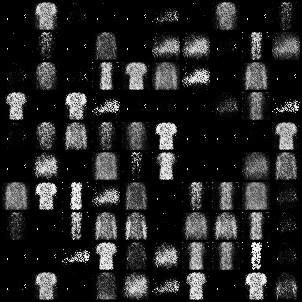

In [27]:
Image('./samples/fake_images-0010.png')

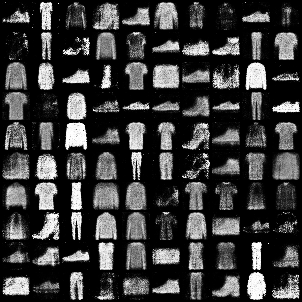

In [28]:
Image('./samples/fake_images-0050.png')

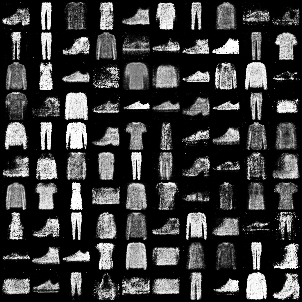

In [29]:
Image('./samples/fake_images-0100.png')

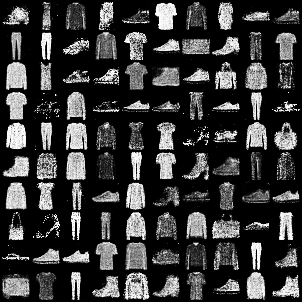

In [30]:
Image('./samples/fake_images-0300.png')

It iterates over three hundred number of epochs, trains the discriminator and generator networks alternatively using batched data from a data loader, and logs the discriminator and generator losses along with real and fake scores. As iterating over three hundred number of epochs it is taking about 1 hour to complete all the epochs.

##### Saving the weights.

In [31]:
# Save the model checkpoints
torch.save(generator_lsgan.state_dict(), 'weights/generator_lsgan_weight')
torch.save(discriminator_lsgan.state_dict(), 'weights/discriminator_lsgan_weight')

##### Loading the weights.

In [32]:
import torch
gen_state_dict = torch.load('weights/generator_lsgan_weight')
discriminator_state_dict = torch.load('weights/discriminator_lsgan_weight')

##### Re-training the LSGAN model

In [33]:
discriminator_lsgan_new = nn.Sequential(
    nn.Linear(input_image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
)

In [34]:
# Define generator network
input_generator = 64

generator_lsgan_new = nn.Sequential(
    nn.Linear(input_generator, hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size, input_image_size),
    nn.Tanh()
)

In [35]:
# Define optimizers
d_optimizer_lsgan_new = torch.optim.Adam(discriminator_lsgan_new.parameters(), lr=0.0002)
g_optimizer_lsgan_new = torch.optim.Adam(generator_lsgan_new.parameters(), lr=0.0002)

# Define LSGAN loss function
lsgan_loss = nn.MSELoss()


##### Discriminator training

In [36]:
def reset_grad():
    d_optimizer_lsgan_new.zero_grad()
    g_optimizer_lsgan_new.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator_lsgan_new(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator_lsgan_new(z)
    outputs = discriminator_lsgan_new(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer_lsgan_new.step()

    return d_loss, real_score, fake_score

##### Generator training

In [37]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator_lsgan_new(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator_lsgan_new(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer_lsgan_new.step()
    return g_loss, fake_images

In [38]:
# Continuing training from epoch 301 to epoch 350
num_epochs = 300
num_epochs_additional = 50  # Number of additional epochs
starting_epoch = num_epochs + 1  # Start from epoch 301

for epoch in range(starting_epoch, starting_epoch + num_epochs_additional):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator loss for real images
        real_outputs = discriminator_lsgan_new(images)
        d_loss_real = lsgan_loss(real_outputs, real_labels)

        # Generate fake images and compute discriminator loss for fake images
        z = torch.randn(batch_size, input_generator).to(device)
        fake_images = generator_lsgan_new(z)
        fake_outputs = discriminator_lsgan_new(fake_images.detach())
        d_loss_fake = lsgan_loss(fake_outputs, fake_labels)

        # Combine discriminator losses
        d_loss = d_loss_real + d_loss_fake

        # Backpropagation and optimization for discriminator
        d_optimizer_lsgan_new.zero_grad()
        d_loss.backward()
        d_optimizer_lsgan_new.step()

        # Train the generator
        fake_outputs = discriminator_lsgan_new(fake_images)
        g_loss = lsgan_loss(fake_outputs, real_labels)

        # Backpropagation and optimization for generator
        g_optimizer_lsgan_new.zero_grad()
        g_loss.backward()
        g_optimizer_lsgan_new.step()

        # Logging
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(torch.mean(real_outputs).item())
            fake_scores.append(torch.mean(fake_outputs).item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs + num_epochs_additional, i+1, total_step, d_loss.item(), g_loss.item(),
                          torch.mean(real_outputs).item(), torch.mean(fake_outputs).item()))

    # Sample and save images
    save_fake_images(epoch)


Epoch [301/350], Step [200/600], d_loss: 0.0072, g_loss: 1.3261, D(x): 0.98, D(G(z)): -0.15
Epoch [301/350], Step [400/600], d_loss: 0.0176, g_loss: 1.2502, D(x): 0.96, D(G(z)): -0.12
Epoch [301/350], Step [600/600], d_loss: 0.0323, g_loss: 1.1504, D(x): 0.97, D(G(z)): -0.07
Saving fake_images-0301.png
Epoch [302/350], Step [200/600], d_loss: 0.0160, g_loss: 1.1629, D(x): 1.03, D(G(z)): -0.08
Epoch [302/350], Step [400/600], d_loss: 0.0128, g_loss: 1.1738, D(x): 0.96, D(G(z)): -0.08
Epoch [302/350], Step [600/600], d_loss: 0.0542, g_loss: 1.1444, D(x): 0.93, D(G(z)): -0.07
Saving fake_images-0302.png
Epoch [303/350], Step [200/600], d_loss: 0.0251, g_loss: 1.1304, D(x): 0.95, D(G(z)): -0.06
Epoch [303/350], Step [400/600], d_loss: 0.0615, g_loss: 1.0415, D(x): 0.88, D(G(z)): -0.02
Epoch [303/350], Step [600/600], d_loss: 0.0233, g_loss: 0.9879, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0303.png
Epoch [304/350], Step [200/600], d_loss: 0.0191, g_loss: 1.2569, D(x): 0.98, D(G(z)): -0.

Epoch [328/350], Step [400/600], d_loss: 0.1157, g_loss: 0.9263, D(x): 0.86, D(G(z)): 0.05
Epoch [328/350], Step [600/600], d_loss: 0.1079, g_loss: 0.9683, D(x): 0.82, D(G(z)): 0.03
Saving fake_images-0328.png
Epoch [329/350], Step [200/600], d_loss: 0.1652, g_loss: 0.6686, D(x): 0.82, D(G(z)): 0.20
Epoch [329/350], Step [400/600], d_loss: 0.0937, g_loss: 0.9929, D(x): 0.92, D(G(z)): 0.01
Epoch [329/350], Step [600/600], d_loss: 0.1282, g_loss: 0.8678, D(x): 0.84, D(G(z)): 0.08
Saving fake_images-0329.png
Epoch [330/350], Step [200/600], d_loss: 0.1591, g_loss: 0.8436, D(x): 0.77, D(G(z)): 0.09
Epoch [330/350], Step [400/600], d_loss: 0.1711, g_loss: 0.8441, D(x): 0.94, D(G(z)): 0.10
Epoch [330/350], Step [600/600], d_loss: 0.1644, g_loss: 0.8267, D(x): 0.87, D(G(z)): 0.10
Saving fake_images-0330.png
Epoch [331/350], Step [200/600], d_loss: 0.1949, g_loss: 0.7451, D(x): 0.81, D(G(z)): 0.16
Epoch [331/350], Step [400/600], d_loss: 0.1688, g_loss: 0.9629, D(x): 0.84, D(G(z)): 0.04
Epoch 

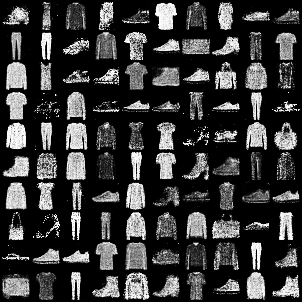

In [39]:
Image('./samples/fake_images-0320.png')

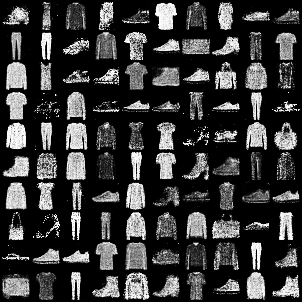

In [40]:
Image('./samples/fake_images-0330.png')

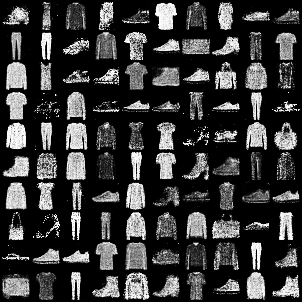

In [41]:
Image('./samples/fake_images-0340.png')

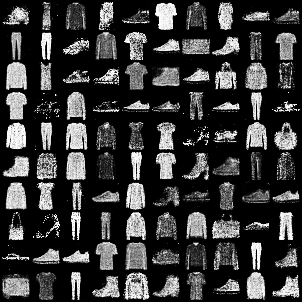

In [42]:
Image('./samples/fake_images-0350.png')

After 350 epochs, there was observed that decreasing losses of d_loss, g_loss indicate that both the discriminator and generator are learning and improving over the course of training. Increasing value of D(x) indicates that the discriminator is becoming more confident in correctly classifying real images as real and D(G(z)) value is decreasing and tend close to zero which means that generator is producing images that are becoming increasingly realistic to the discriminator.

##### Saving the weights

In [44]:
torch.save(discriminator_lsgan_new.state_dict(), 'weights/discriminator_lsgan_after_retraining_weight')
torch.save(generator_lsgan_new.state_dict(), 'weights/generator_lsgan_after_retraining_weight')

##### Loading the weights.

In [45]:
import torch
gen_state_dict = torch.load('weights/generator_lsgan_after_retraining_weight')
discriminator_state_dict = torch.load('weights/discriminator_lsgan_after_retraining_weight')

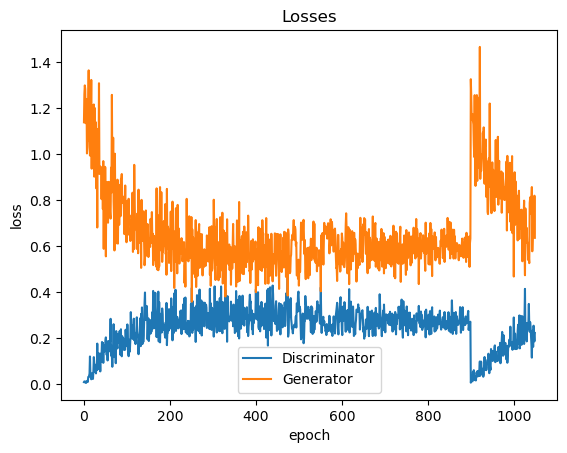

In [46]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

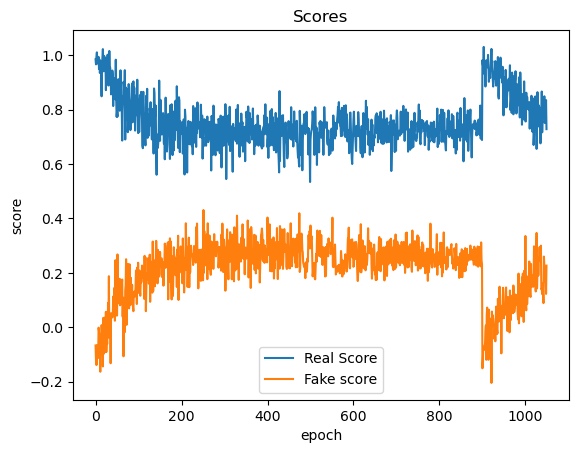

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

After using the LSGAN, there are better results observed when compared to GAN model, the g_loss and d_loss was decreased,indicate that both the discriminator and generator are learning and improving over the course of training. Increasing value of D(x) indicates that the discriminator is becoming more confident in correctly classifying real images as real and D(G(z)) value is decreasing and tend close to zero which means that generator is producing images that are becoming increasingly realistic to the discriminator. 